In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import pandas as pd
import random
import cv2
import torch.optim as optim
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import DataLoader
from skimage.io import imread
from skimage.measure import label, regionprops
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from detectron2.utils.logger import setup_logger

setup_logger()
import logging

logging.getLogger("detectron2.data.dataset_mapper").setLevel(logging.WARNING)

from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, detection_utils as utils, DatasetMapper, \
    build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.modeling import build_model
from detectron2.structures import ImageList, Instances
from detectron2.checkpoint import DetectionCheckpointer
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import LazyConfig, instantiate

print(torch.cuda.is_available())
print(torch.version.cuda)
%matplotlib inline

True
12.1


In [2]:
from Dataset import Dataset

category = 'ship'
dataset = Dataset('airbus', category_id=0)
img_dir = '/home/oraja001/airbus_ship/airbus/train_v2'

train_df, valid_df = dataset.airbus_df()
DatasetCatalog.register('val_data', lambda: dataset.airbus_dicts(df=valid_df[:500], img_dir=img_dir))
MetadataCatalog.get('val_data').set(thing_classes=[category])

# coco_classes = MetadataCatalog.get('coco_2017_train').thing_classes.copy()
# coco_classes[8] = 'ship'
# MetadataCatalog.get('val_data').set(thing_classes=coco_classes)

val_data_len = len(DatasetCatalog.get('val_data'))
val_metadata = MetadataCatalog.get("val_data")

val_airbus_dicts = dataset.airbus_dicts(valid_df[:500], img_dir=img_dir)

Total number of images (original): 192556
Total number of images (after removing corrupted images): 192555
Number of images with ships : 42556 | Number of images without ships : 149999  (x3.5)


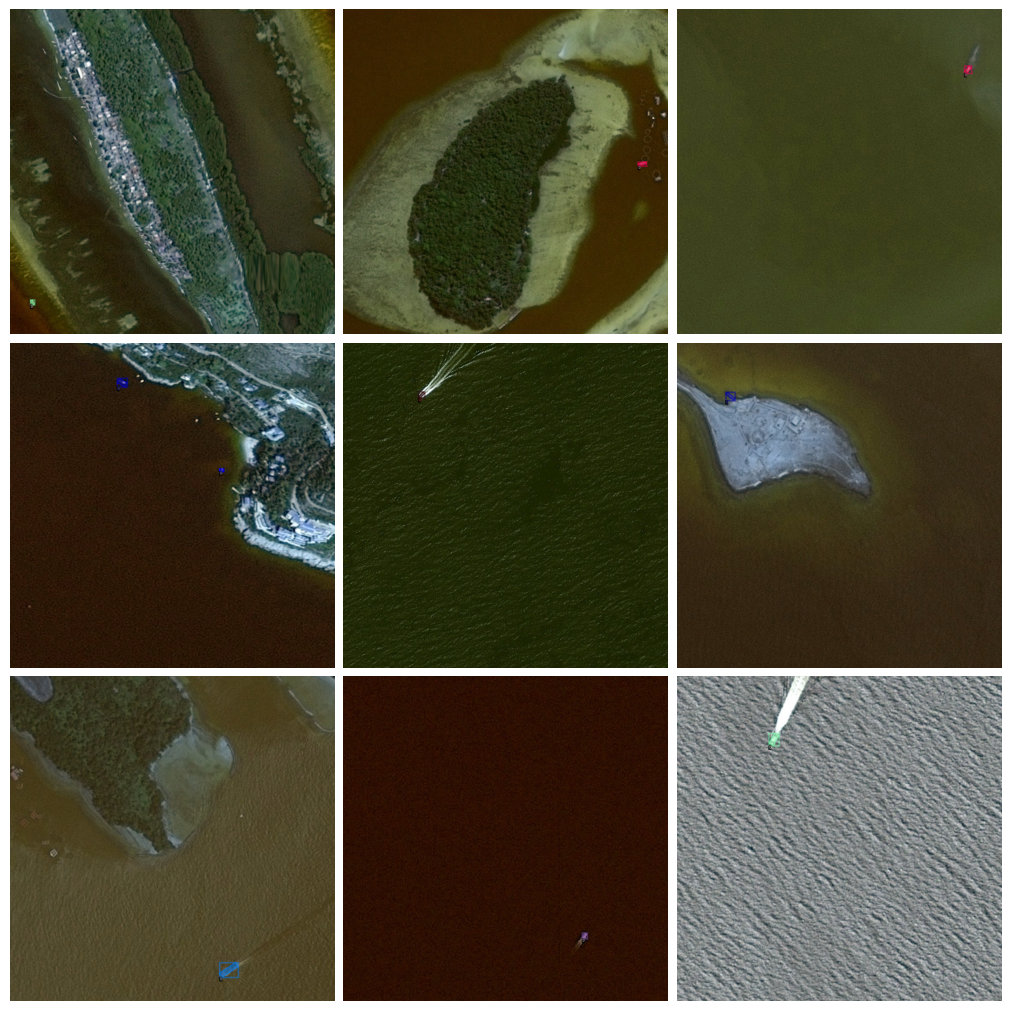

In [3]:
fig, arr = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True)
for i, d in enumerate(random.sample(val_airbus_dicts, 9)):
    img = cv2.imread(f'{d["file_name"]}')
    visualizer = Visualizer(img[:, :, ::-1], scale=1.0)
    # print(d)

    r = int(i / 3)
    c = i % 3
    out = visualizer.draw_dataset_dict(d)
    arr[r, c].imshow(out.get_image()[:, :, ::-1])
    arr[r, c].axis('off')
plt.show()

In [4]:
from DetectionNetwork import DetectionNetwork, LazyPredictor
from YOLO import YOLOPredictor
transformer_based = False
yolo_based = True

if yolo_based:
    detection_network = DetectionNetwork(output_dir="/home/oraja001/airbus_ship/AdversarialProject/outputs/yolo",
                                model_path="/home/oraja001/airbus_ship/AdversarialProject/trained_models/yolo/yolov8l.pt",
                                batch_size=4,
                                learning_rate=1e-4,
                                epoch_num=10, 
                                num_classes=1,
                                attack_name=None)
    detection_model, cfg = detection_network.yolo_model_net(model_config="/home/oraja001/airbus_ship/AdversarialProject/yolo_configs/yolov8_l.yaml",
                                                  train_data_len=0)
    detection_model.load_state_dict(torch.load("/home/oraja001/airbus_ship/AdversarialProject/trained_models/yolo/custom_yolo.pt"))
    predictor = YOLOPredictor(detection_model, [8,16,32], [category], conf_thres=.1, iou_thres=0.3)
elif transformer_based:
    detection_network = DetectionNetwork(output_dir="/home/oraja001/airbus_ship/AdversarialProject/outputs/mask_rcnn_vitdet",
                                model_path="/home/oraja001/airbus_ship/AdversarialProject/trained_models/mask_rcnn_vitdet/model_0001499.pth",
                                batch_size=4,
                                learning_rate=1e-4,
                                epoch_num=10, 
                                num_classes=1,
                                attack_name=None)
    detection_model, cfg = detection_network.transformer_based_net(model_config="/home/oraja001/airbus_ship/detectron2/projects/ViTDet/configs/COCO/mask_rcnn_vitdet_b_100ep.py", 
                                                                   train_data_len=0)
    
    cfg.model.roi_heads.box_predictor.test_score_thresh = 0.5
    # cfg.model.roi_heads.box_predictors[-1].test_score_thresh = 0.5
    predictor = LazyPredictor(cfg)
else:
    detection_network = DetectionNetwork(output_dir="/home/oraja001/airbus_ship/AdversarialProject/outputs/mask_rcnn_R_101_FPN_3x",
                                    model_path="/home/oraja001/airbus_ship/AdversarialProject/trained_models/mask_rcnn_R_101_FPN_3x/model_final_ship.pth",
                                    batch_size=4,
                                    learning_rate=1e-4,
                                    epoch_num=10, 
                                    num_classes=1,
                                    attack_name=None)
    detection_model, cfg = detection_network.detectron_net(model_config="COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml",
                                                           train_data_len=0)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
    # cfg.MODEL.ROI_HEADS.NMS_THTESH_TEST = .3
    # cfg.MODEL.ROI_HEADS.NMS_THTESH_TEST = .3
    predictor = DefaultPredictor(cfg)

parameters_count = sum(p.numel() for p in detection_model.parameters())
print(f"Number of parameters to be trained is: {parameters_count}")

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 76, 77}
Loaded Conv blocks: 69/87
Coverage: 79.3%
Number of parameters to be trained is: 70094083


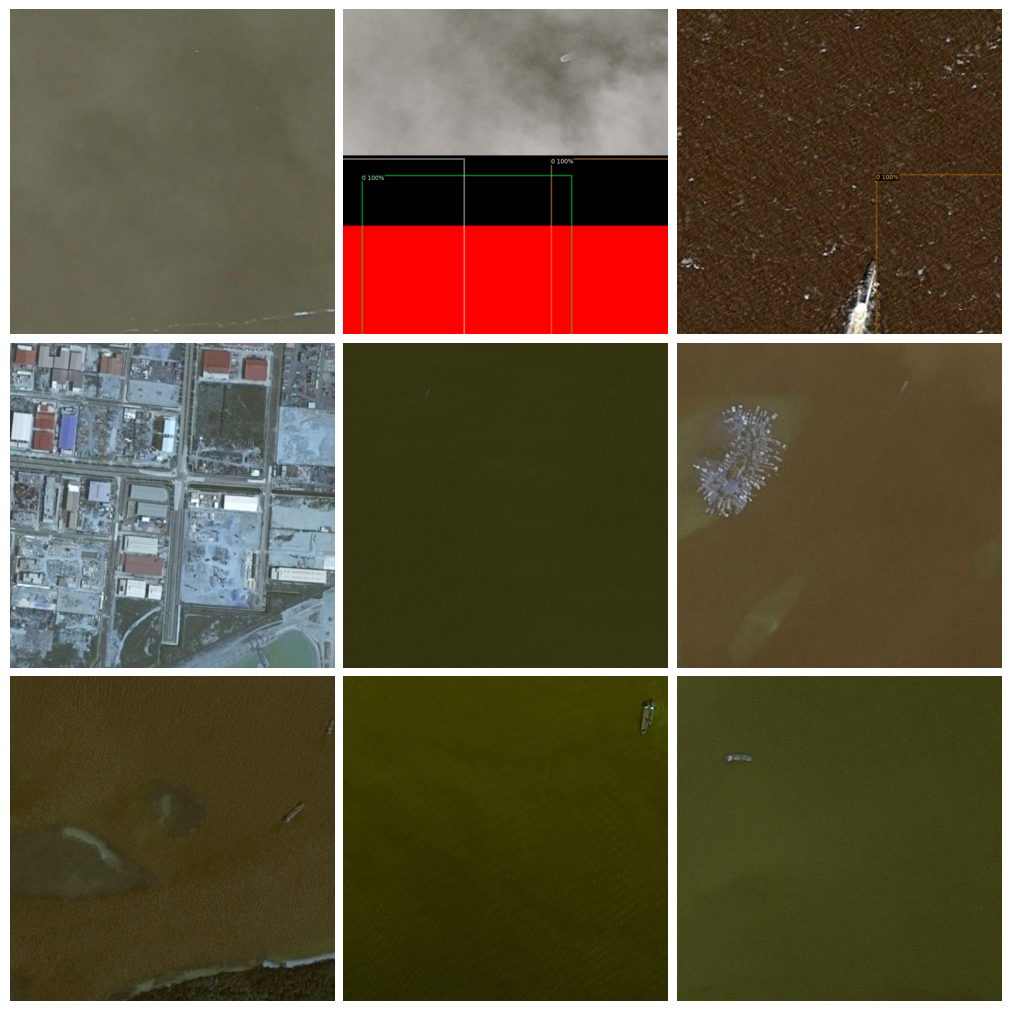

In [5]:
fig, arr = plt.subplots(3, 3, figsize=(10, 10), constrained_layout=True)
for i, d in enumerate(random.sample(val_airbus_dicts, 9)):
    im = cv2.imread(d["file_name"])
    height, width = im.shape[:2]
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                #    scale=.5,
                   # instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    r = int(i / 3)
    c = i % 3
    arr[r, c].imshow(out.get_image()[:, :, ::-1])
    arr[r, c].axis('off')
plt.show()

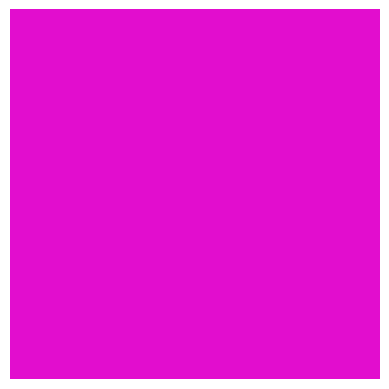

In [6]:
poisoning_func = 'shapeAware'
parameters_name = f"/home/oraja001/airbus_ship/AdversarialProject/outputs/rl_optimization"
if transformer_based:
    mean = torch.tensor(cfg.model.pixel_mean).view(1, 3, 1, 1)
elif yolo_based:
    mean = torch.tensor([103.53, 116.28, 123.675]).view(1, 3, 1, 1)
else:
    mean = torch.tensor(cfg.MODEL.PIXEL_MEAN).view(1, 3, 1, 1)
    
std = torch.tensor([57.3750, 57.1200, 58.3950]).view(1, 3, 1, 1)
# print(torch.load(f'{parameters_name}.pt'))
parameters = ((torch.load(f'{parameters_name}.pt').detach().cpu()) + mean[0]).clamp(0, 255)
# parameters = torch.load(f'{parameters_name}.pt').detach().cpu()
parameters = parameters.numpy().transpose((1, 2, 0))
parameters = np.uint8(parameters)
fig, ax = plt.subplots()
ax.imshow(parameters[:, :, ::-1])
ax.axis('off')
# [103.53, 116.28, 123.675]
# Save the figure
# plt.savefig('parameters_epoch_seg_mask_True_23k.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [7]:
seg_model = detection_network.segmentation_model(MODEL_SEG='UNET_RESNET34ImgNet').to('cuda').eval()
parameters_count = sum(p.numel() for p in seg_model.parameters())
print(f"Number of parameters to be trained is: {parameters_count}")

Number of parameters to be trained is: 24436369


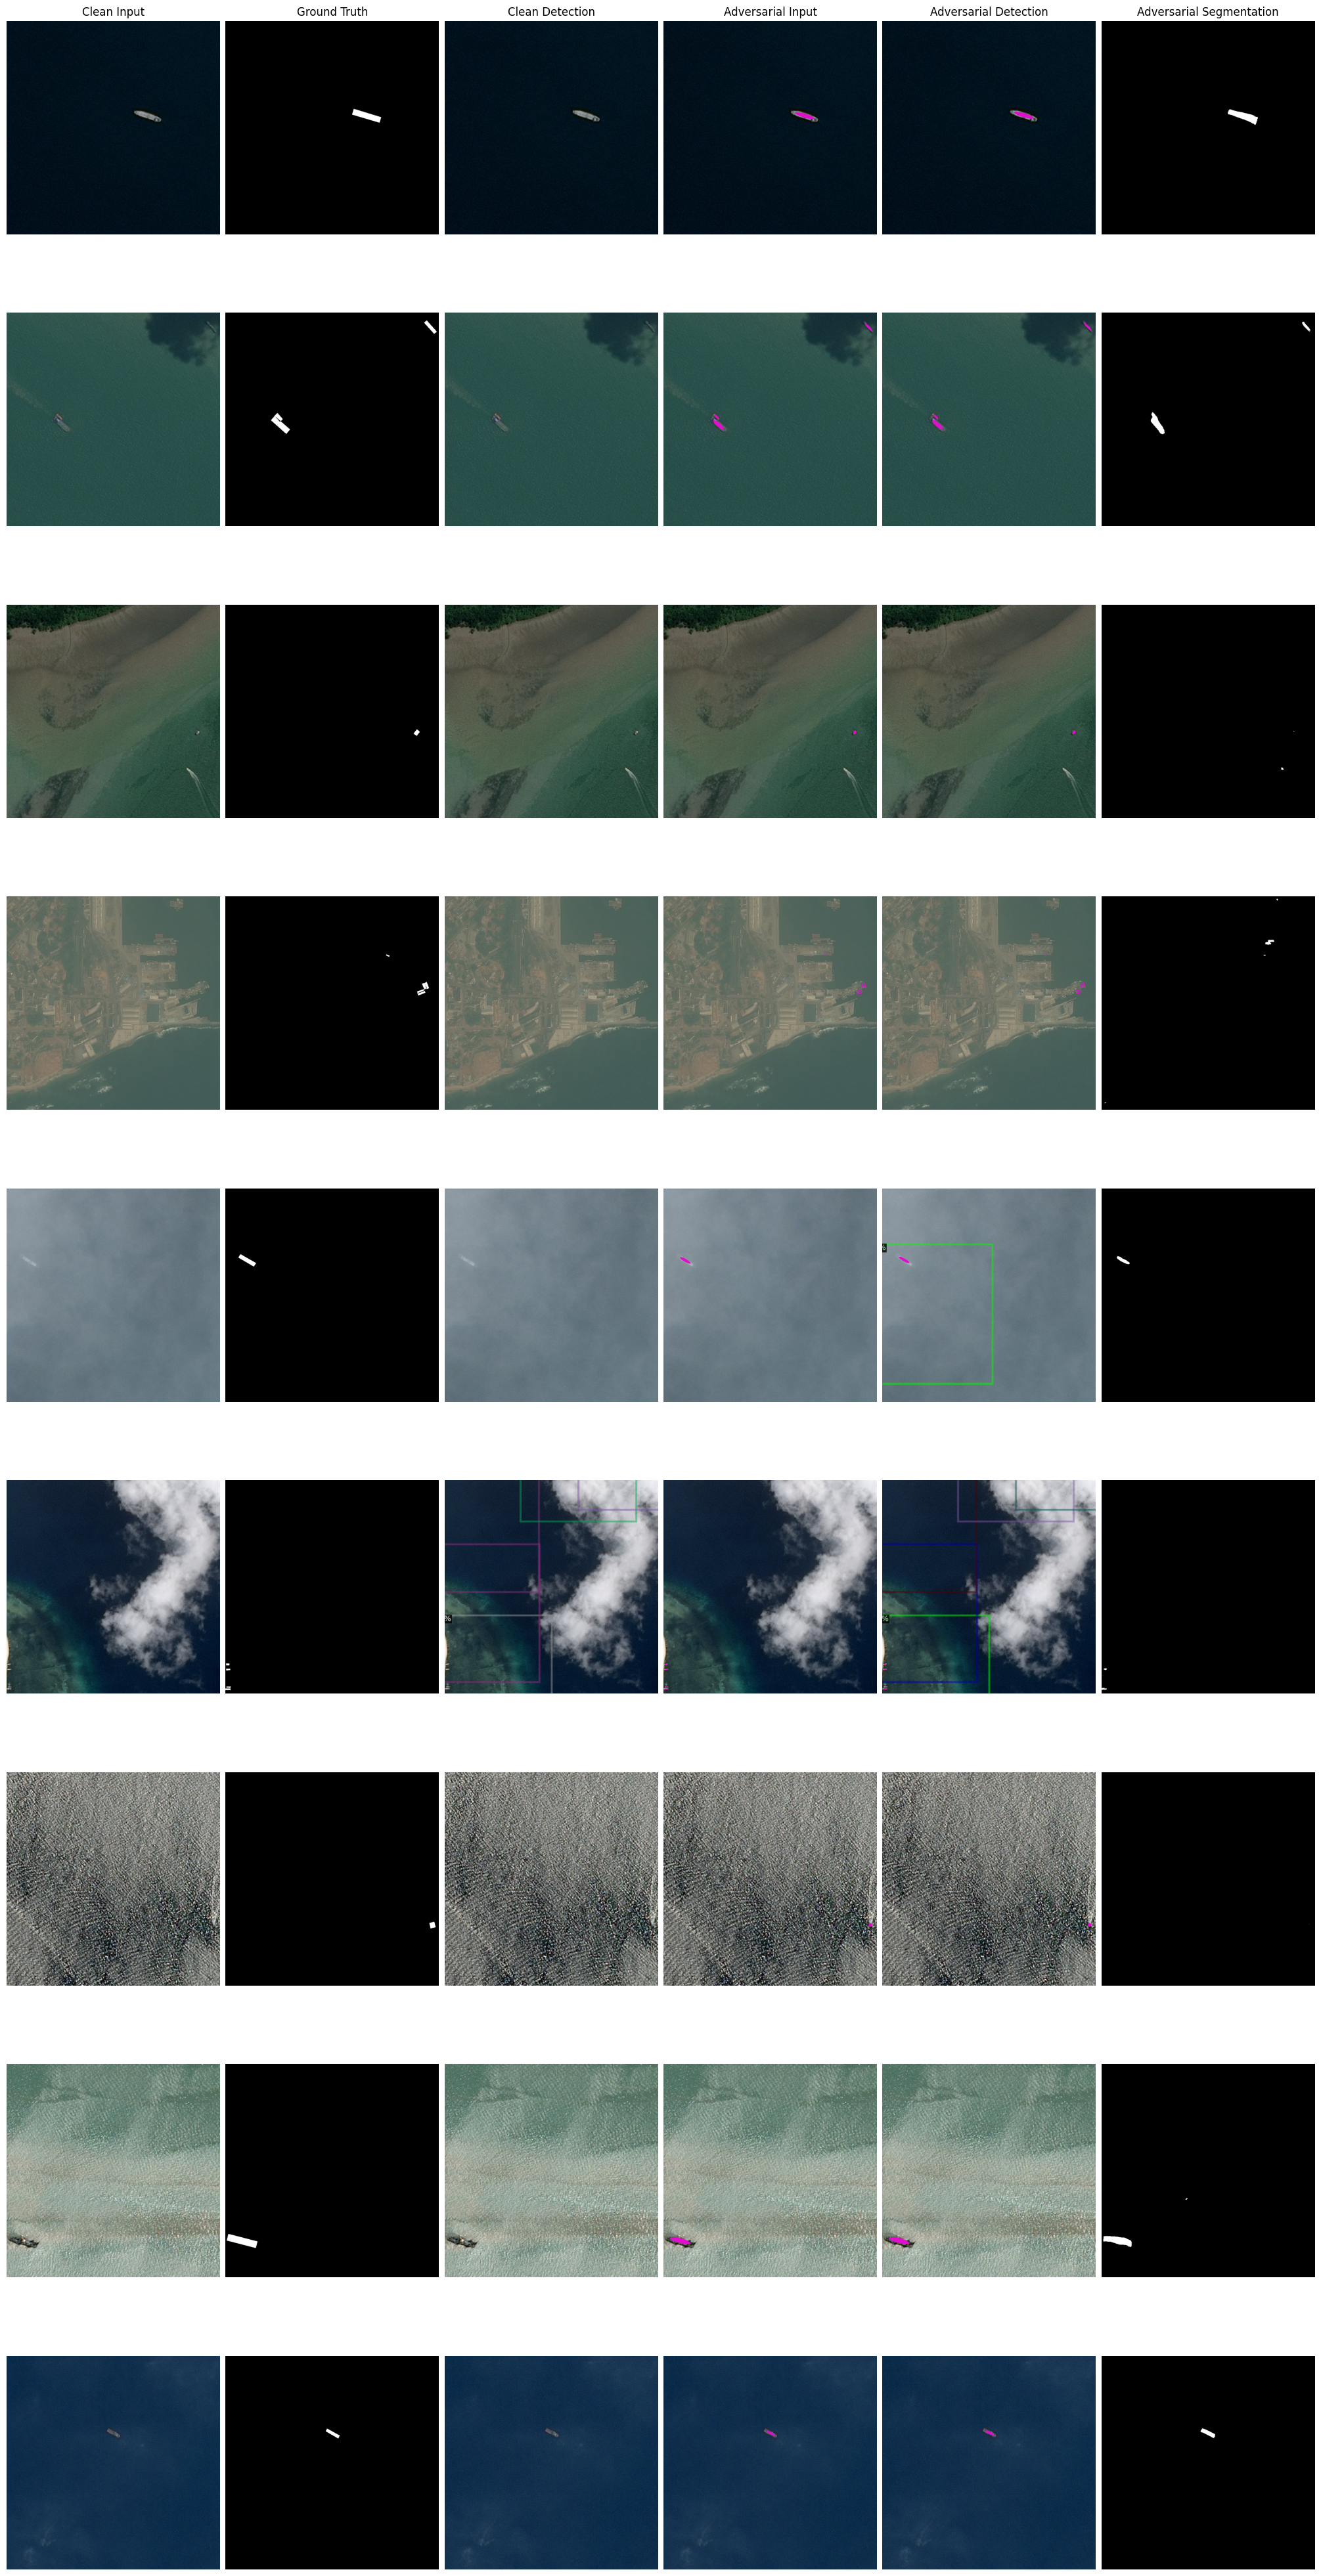

In [8]:
from Poison import Poison

percentage = .6
poison = Poison(prob=1)

fig, arr = plt.subplots(9, 6, figsize=(20, 40), constrained_layout=True)
i=0
for sample in random.sample(val_airbus_dicts, 9):
    im = cv2.imread(sample["file_name"])

    annotations = sample['annotations']

    arr[i, 0 ].imshow(im[:, :, ::-1])
    arr[0, 0].set_title('Clean Input')
    arr[i, 0].axis('off')

    binary_masks = []
    bin_mask = np.zeros((sample['height'], sample['width']), dtype=np.uint8)
    for ann in annotations:
        binary_mask = np.zeros((sample['height'], sample['width']), dtype=np.uint8)
        polygon = np.array(ann['segmentation'][0]).reshape((-1, 1, 2))
        binary_mask = cv2.fillPoly(binary_mask, [polygon], 1)
        binary_masks.append(binary_mask)
        bin_mask += binary_mask 


    arr[i, 1].imshow(bin_mask > 0, 'gray')
    arr[0, 1].set_title('Ground Truth')
    arr[i, 1].axis('off')

    
    clean_outputs = predictor(im.copy())  
    v = Visualizer(im.copy(),
                   scale=.5,
                #    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    clean_out = v.draw_instance_predictions(clean_outputs["instances"].to("cpu"))

    im = (torch.tensor(im).permute(2, 0, 1) - mean[0]).to('cuda')
    patch = torch.load(f'{parameters_name}.pt').to('cuda')
    # patch = (torch.load(f'{parameters_name}.pt').to('cuda')- mean[0].to('cuda'))/std[0].to('cuda')
    if poisoning_func in ['google', 'shapeShifter']:
        adv_img  = poison.google_poisoning(im,
                                           patch=patch,
                                           percentage=percentage, 
                                           masks=binary_masks, 
                                           training=False)
    elif poisoning_func == 'Dpatch':
        adv_img  = poison.dpatch_poisoning(im,
                                           patch=patch,
                                           masks=binary_masks,
                                            training=False)
    elif poisoning_func == 'scaleAdaptive':
         adv_img  = poison.scaleAdaptive_poisoning(im,
                                                   patch=patch,
                                                   alpha=percentage,
                                                   masks=binary_masks, 
                                                   training=False)
    elif poisoning_func == 'shapeAware': 
        adv_img = poison.shapeAware_poisoning(im,
                                              patch=patch,
                                              shape='ellipse',
                                              percentage=percentage,
                                              masks=binary_masks, 
                                              training=False)
    elif poisoning_func == 'pieceWise':
        adv_img = poison.pieceWise_poisoning(im,
                                            patch=patch,
                                            shape='ellipse',
                                            percentage=percentage,
                                            masks=binary_masks, 
                                            training=False)
    else:
        adv_img = None

    seg_output = seg_model((adv_img.unsqueeze(0).to('cuda'))/std[0].to('cuda'))[0]

    adv_img = (adv_img + mean[0].to('cuda')).clamp(0, 255)
    # adv_img = torch.tensor(adv_img, dtype=torch.uint8)


    adv_outputs = predictor(adv_img.detach().cpu().numpy().transpose((1, 2, 0)))  
    v = Visualizer(adv_img.detach().cpu().numpy().transpose((1, 2, 0)),
                   scale=.5,
                #    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    adv_out = v.draw_instance_predictions(adv_outputs["instances"].to("cpu"))


    arr[i, 2].imshow(clean_out.get_image()[:, :, ::-1])
    arr[0, 2].set_title('Clean Detection')
    arr[i, 2].axis('off')

    arr[i, 3].imshow(np.uint8(adv_img.detach().cpu().numpy().transpose((1, 2, 0)))[:, :, ::-1])
    arr[0, 3].set_title('Adversarial Input')
    arr[i, 3].axis('off')

    arr[i, 4].imshow(adv_out.get_image()[:, :, ::-1])
    arr[0, 4].set_title('Adversarial Detection')
    arr[i, 4].axis('off')

    arr[i, 5].imshow(seg_output.detach().cpu().numpy()[0]>0, 'gray')
    arr[0, 5].set_title('Adversarial Segmentation')
    arr[i, 5].axis('off')

    i+=1
    
plt.show()

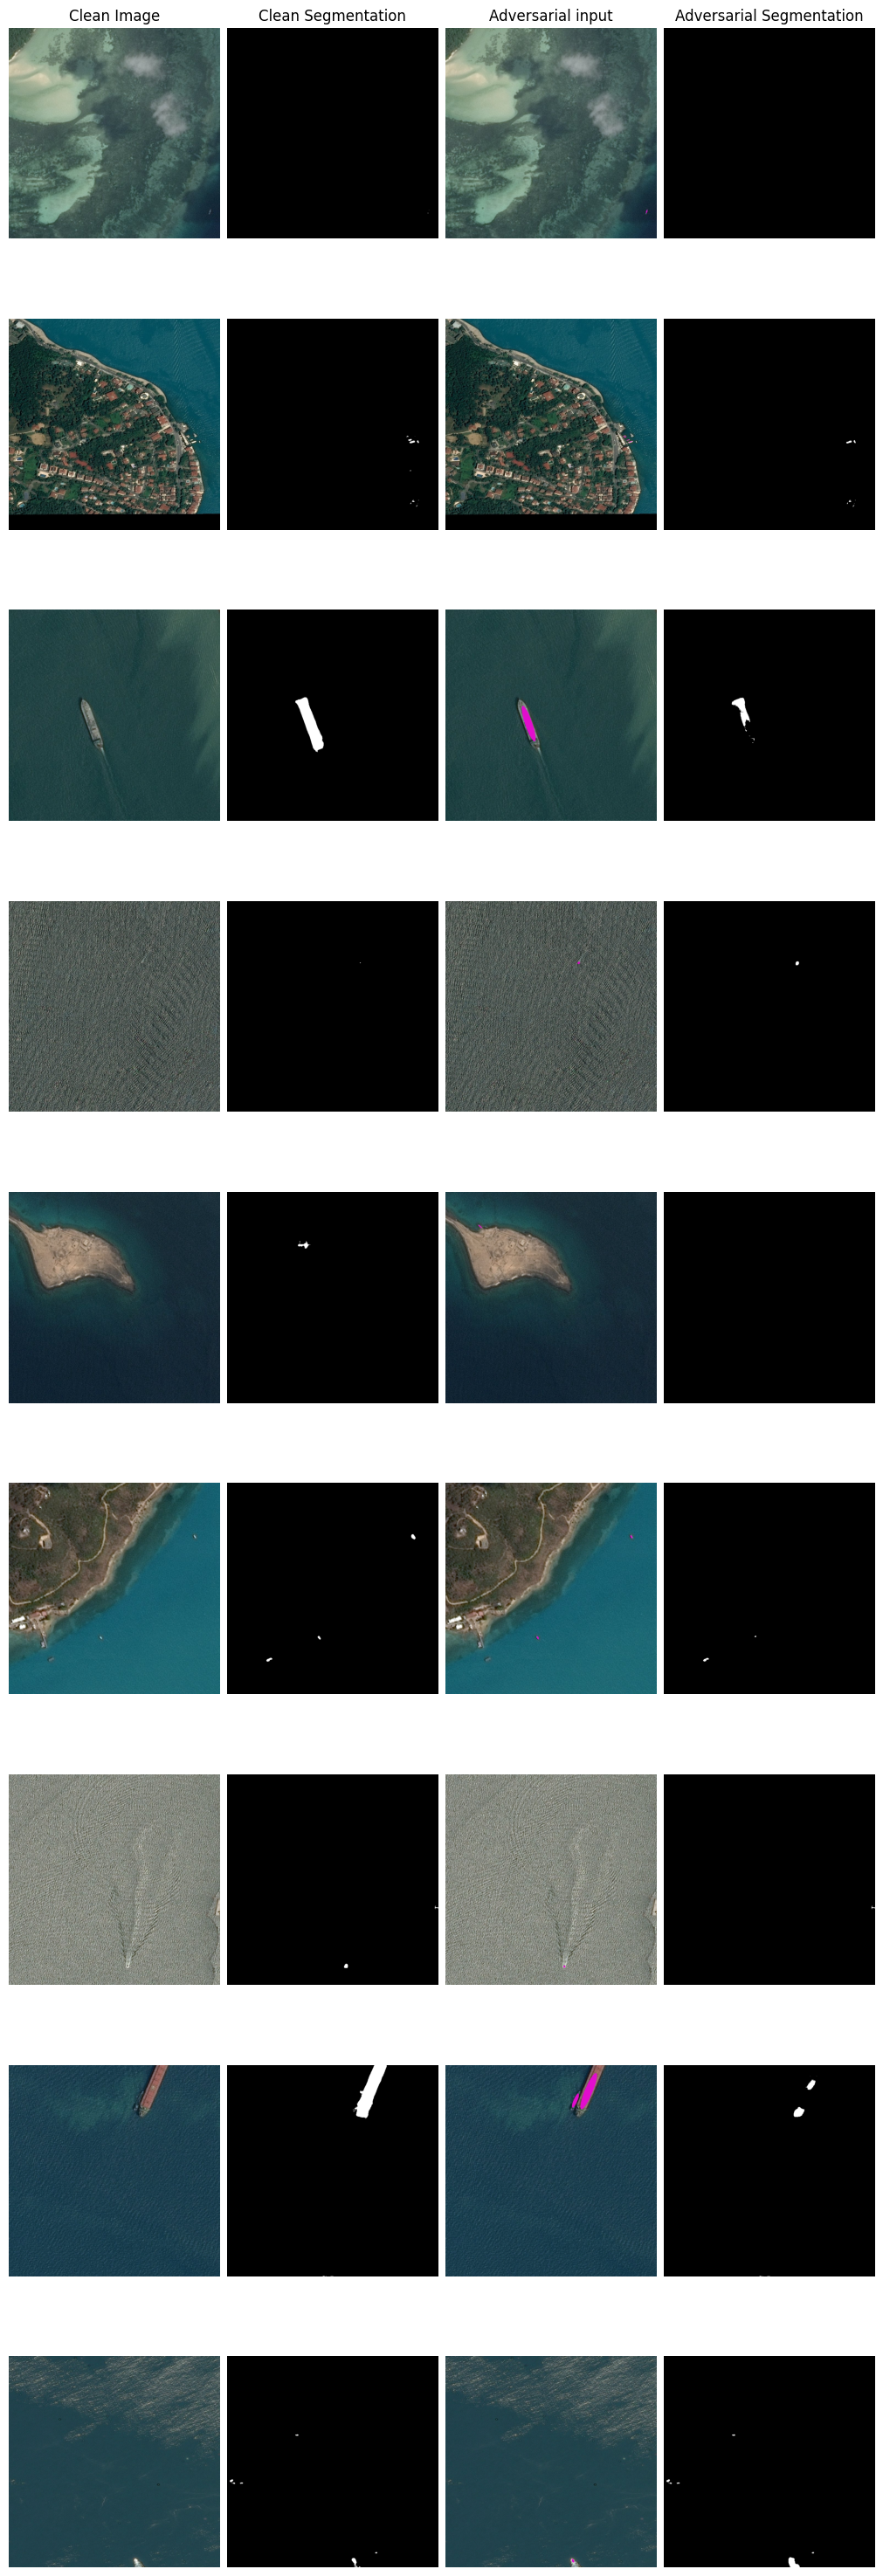

In [9]:
from Poison import Poison

poison = Poison(prob=1)

fig, arr = plt.subplots(9, 4, figsize=(10, 30), constrained_layout=True)
i=0
for sample in random.sample(val_airbus_dicts, 9):
    im = cv2.imread(sample["file_name"])

    annotations = sample['annotations']

    binary_masks = []
    bin_mask = np.zeros((sample['height'], sample['width']), dtype=np.uint8)
    for ann in annotations:
        binary_mask = np.zeros((sample['height'], sample['width']), dtype=np.uint8)
        polygon = np.array(ann['segmentation'][0]).reshape((-1, 1, 2))
        binary_mask = cv2.fillPoly(binary_mask, [polygon], 1)
        binary_masks.append(binary_mask)
        bin_mask += binary_mask 


    # arr[i, 0 ].imshow(bin_mask > 0, 'gray')
    # arr[0, 0].set_title('Ground Truth')
    # arr[i, 0].axis('off')

    arr[i, 0 ].imshow(im[:, :, ::-1])
    arr[0, 0].set_title('Clean Image')
    arr[i, 0].axis('off')

    clean_output = seg_model.forward(((torch.tensor(im.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0)-mean)/std).to('cuda'))[0]
    clean_output = ((clean_output > 0).float())
    clean_output = clean_output.cpu().numpy().transpose((1, 2, 0))
    clean_output = np.clip(clean_output, 0, 1)

    arr[i, 1].imshow(clean_output[:, :, 0], 'gray')
    arr[0, 1].set_title('Clean Segmentation')
    arr[i, 1].axis('off')



    im = ((torch.tensor(im).permute(2, 0, 1)) - mean[0]).to('cuda')
    if poisoning_func in ['google', 'shapeShifter']:
        adv_img  = poison.google_poisoning(im,
                                           patch=patch,
                                           percentage=percentage, 
                                           masks=binary_masks, 
                                           training=False)
    elif poisoning_func == 'Dpatch':
        adv_img  = poison.dpatch_poisoning(im,
                                           patch=patch,
                                           masks=binary_masks,
                                            training=False)
    elif poisoning_func == 'scaleAdaptive':
         adv_img  = poison.scaleAdaptive_poisoning(im,
                                                   patch=patch,
                                                   alpha=percentage,
                                                   masks=binary_masks, 
                                                   training=False)
    elif poisoning_func == 'shapeAware': 
        adv_img = poison.shapeAware_poisoning(im,
                                              patch=patch,
                                              shape='ellipse',
                                              percentage=percentage,
                                              masks=binary_masks, 
                                              training=False)
    elif poisoning_func == 'pieceWise':
        adv_img = poison.pieceWise_poisoning(im,
                                            patch=patch,
                                            shape='ellipse',
                                            percentage=percentage,
                                            masks=binary_masks, 
                                            training=False)
    else:
        adv_img = None

    
    adv_output = seg_model((adv_img.unsqueeze(0).to('cuda'))/std[0].to('cuda'))[0]

    adv_img = (adv_img.cpu() + mean[0])
    adv_img = torch.permute(adv_img, (1, 2, 0)).clamp(0, 255)
    adv_img = torch.tensor(adv_img, dtype=torch.uint8)

    arr[i, 2].imshow(adv_img.detach().cpu().numpy()[:, :, ::-1])
    arr[0, 2].set_title('Adversarial input')
    arr[i, 2].axis('off')

    arr[i, 3].imshow(adv_output.detach().cpu().numpy()[0]>0, 'gray')
    arr[0, 3].set_title('Adversarial Segmentation')
    arr[i, 3].axis('off')

    i+=1
    
plt.show()

In [10]:
# Custom mapper with additional transformations
class CustomDatasetMapperCNN(DatasetMapper):
    def __init__(self, cfg, is_train=True, percentage=0.6, poisoning=None):
        self.percentage = percentage
        self.poisoning = poisoning
        super().__init__(cfg, is_train, augmentations=[])

    def __call__(self, dataset_dict):
        dataset_dict = super().__call__(dataset_dict)
        image = dataset_dict["image"]
        polygons = dataset_dict['instances'].gt_masks

        binary_masks = []
        for polygon in polygons:
            binary_mask = np.zeros((dataset_dict['image'].shape[1], dataset_dict['image'].shape[2]), dtype=np.uint8)
            polygon = polygon[0].reshape((-1, 1, 2))
            binary_mask = cv2.fillPoly(binary_mask, [np.array(polygon, dtype=np.int32)], 1)
            binary_masks.append(binary_mask)
        
        image = (image - mean[0])
        if self.poisoning in ['google', 'shapeShifter']:
            adv_img = poison.google_poisoning(image.to('cuda'), patch=patch, percentage=self.percentage, masks=binary_masks, training=False)
        elif self.poisoning == 'Dpatch':
            adv_img = poison.dpatch_poisoning(image.to('cuda'), patch=patch, masks=binary_masks, training=False)
        elif self.poisoning == 'scaleAdaptive':
            adv_img = poison.scaleAdaptive_poisoning(image.to('cuda'), patch=patch, alpha=self.percentage, masks=binary_masks, training=False)
        elif self.poisoning == 'shapeAware':
            adv_img = poison.shapeAware_poisoning(image.to('cuda'), patch=patch, shape='ellipse', percentage=self.percentage, masks=binary_masks, training=False)
        elif self.poisoning == 'pieceWise':
            adv_img = poison.pieceWise_poisoning(image.to('cuda'), patch=patch, shape='ellipse', percentage=self.percentage, masks=binary_masks, training=False)
        else:
            adv_img = image.to('cuda')
        

        adv_img = (adv_img + mean[0].to('cuda')).clamp(0, 255)
        adv_img = torch.tensor(adv_img, dtype=torch.uint8)
        
        dataset_dict["image"] = adv_img
        return dataset_dict


class CustomDatasetMapperTransformer:
    def __init__(self, cfg, is_train=True, percentage=0.6, poisoning=None):
        self.percentage = percentage
        self.poisoning = poisoning
        self.aug = []
        self.cfg = cfg
        self.cfg.dataloader.test.mapper.is_train = is_train  # force annotation loading
        self.cfg.dataloader.test.mapper.use_instance_mask = is_train
        self.cfg.dataloader.test.mapper.recompute_boxes = is_train  # useful for masks->boxes
        self.cfg.dataloader.test.num_workers = 0
        val_loader = instantiate(self.cfg.dataloader.test)
        self.default_mapper = val_loader.dataset._map_func  # the default DatasetMapper

    def __call__(self, dataset_dict):
        dataset_dict = self.default_mapper(dataset_dict)
        image = dataset_dict["image"]
        polygons = dataset_dict['instances'].gt_masks

        binary_masks = []
        for polygon in polygons:
            binary_mask = np.zeros((dataset_dict['image'].shape[1], dataset_dict['image'].shape[2]), dtype=np.uint8)
            polygon = polygon[0].reshape((-1, 1, 2))
            binary_mask = cv2.fillPoly(binary_mask, [np.array(polygon, dtype=np.int32)], 1)
            binary_masks.append(binary_mask)
        
        image = (image - mean[0])
        if self.poisoning in ['google', 'shapeShifter']:
            adv_img = poison.google_poisoning(image.to('cuda'), patch=patch, percentage=self.percentage, masks=binary_masks, training=False)
        elif self.poisoning == 'Dpatch':
            adv_img = poison.dpatch_poisoning(image.to('cuda'), patch=patch, masks=binary_masks, training=False)
        elif self.poisoning == 'scaleAdaptive':
            adv_img = poison.scaleAdaptive_poisoning(image.to('cuda'), patch=patch, alpha=self.percentage, masks=binary_masks, training=False)
        elif self.poisoning == 'shapeAware':
            adv_img = poison.shapeAware_poisoning(image.to('cuda'), patch=patch, shape='ellipse', percentage=self.percentage, masks=binary_masks, training=False)
        elif self.poisoning == 'pieceWise':
            adv_img = poison.pieceWise_poisoning(image.to('cuda'), patch=patch, shape='ellipse', percentage=self.percentage, masks=binary_masks, training=False)
        else:
            adv_img = image.to('cuda')
        
        

        adv_img = (adv_img + mean[0].to('cuda')).clamp(0, 255)
        adv_img = torch.tensor(adv_img, dtype=torch.uint8)
        
        dataset_dict["image"] = adv_img
        return dataset_dict

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader, DatasetMapper

if transformer_based:
    evaluator = COCOEvaluator(f'val_data', output_dir=cfg.train.output_dir)
    val_loader = instantiate(cfg.dataloader.test)
    val_loader.dataset._map_func = CustomDatasetMapperTransformer(cfg, is_train=True, percentage=0, poisoning=None)
    print(inference_on_dataset(predictor.model, val_loader, evaluator))

    poison_loader = instantiate(cfg.dataloader.test)
    poison_loader.dataset._map_func = CustomDatasetMapperTransformer(cfg, is_train=True, percentage=percentage, poisoning=poisoning_func)
    print(inference_on_dataset(predictor.model, poison_loader, evaluator))
else:
    evaluator = COCOEvaluator(f'val_data', output_dir=cfg.OUTPUT_DIR)
    val_loader = build_detection_test_loader(cfg, f'val_data', mapper=CustomDatasetMapperCNN(cfg, is_train=True, percentage=0, poisoning=None), batch_size=4, num_workers=0)
    print(inference_on_dataset(predictor.model, val_loader, evaluator))

    poison_loader = build_detection_test_loader(cfg, f'val_data', mapper=CustomDatasetMapperCNN(cfg, is_train=True, percentage=percentage, poisoning=poisoning_func), batch_size=4, num_workers=0)
    print(inference_on_dataset(predictor.model, poison_loader, evaluator))

AttributeError: 'dict' object has no attribute 'OUTPUT_DIR'

In [ ]:
import torch
from detectron2.structures import Boxes, pairwise_iou

@torch.no_grad()
def iou_and_counts(pred_boxes: Boxes,
                   pred_scores: torch.Tensor,
                   gt_boxes: Boxes,
                   iou_thresh: float = 0.50):
    """
    Return mean IoU & detected (recall proxy) **plus** TP / FP / FN
    calculated with greedy one-to-one matching at `iou_thresh`.

    Args
    ----
    pred_boxes   : detectron2.structures.Boxes  (N, 4)
    pred_scores  : 1-D tensor (N,)  confidence per prediction
    gt_boxes     : Boxes  (M, 4)
    iou_thresh   : float  IoU threshold for TP/FP

    Returns
    -------
    dict { mean_iou, detected, tp, fp, fn }
    """
    device = pred_boxes.tensor.device
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        mean_iou   = 0.0
        detected   = 0
        tp, fp, fn = 0, len(pred_boxes), len(gt_boxes)
        return dict(mean_iou=mean_iou, detected=detected,
                    tp=tp, fp=fp, fn=fn)

    ious = pairwise_iou(pred_boxes, gt_boxes)

    best_iou_per_gt, _ = ious.max(dim=0)         
    mean_iou = best_iou_per_gt.mean().item()
    detected = (best_iou_per_gt > 0).sum().item()

    _, order = pred_scores.sort(descending=True)
    ious = ious[order]

    matched_gt = torch.zeros(len(gt_boxes), dtype=torch.bool, device=device)
    tp = fp = 0

    for row in ious:
        max_iou, gt_idx = row.max(dim=0)
        if max_iou >= iou_thresh and not matched_gt[gt_idx]:
            tp += 1
            matched_gt[gt_idx] = True
        else:
            fp += 1

    fn = int((~matched_gt).sum())

    return dict(mean_iou=mean_iou,
                detected=detected,
                tp=tp, fp=fp, fn=fn)

In [ ]:
ious = []
detection_numbers = []
gt_sum = 0
TP = 0
FP = 0
FN = 0
for poison_inputs in iter(val_loader):
    for poison_input in poison_inputs:
        adv_outputs = predictor(poison_input['image'].cpu().numpy().transpose((1, 2, 0)))
        metrics_dict = iou_and_counts(adv_outputs['instances'].pred_boxes.to('cuda'), 
                                    adv_outputs['instances'].scores, 
                                    poison_input['instances'].gt_boxes.to('cuda'), iou_thresh=0.5)

        ious.append(metrics_dict['mean_iou'])
        detection_numbers.append(metrics_dict['detected'])
        TP += metrics_dict['tp']
        FP += metrics_dict['fp']
        FN += metrics_dict['fn']
        gt_sum += len(poison_input['instances'].gt_boxes)

avg_iou = np.mean(ious)
asr = 1 - sum(detection_numbers)/gt_sum
Precision = TP/(TP + FP)
Recall = TP/(TP + FN)
F1_score = 2*(Precision*Recall)/(Precision+Recall)

print(f'F1 score: {F1_score}')
print(f'mIoU: {avg_iou}')
print(f'ASR: {asr}')
print(f'Precision: {Precision}')
print(f'Recall: {Recall}')

In [ ]:
ious = []
detection_numbers = []
gt_sum = 0
TP = 0
FP = 0
FN = 0
for poison_inputs in iter(poison_loader):
    for poison_input in poison_inputs:
        adv_outputs = predictor(poison_input['image'].cpu().numpy().transpose((1, 2, 0)))
        metrics_dict = iou_and_counts(adv_outputs['instances'].pred_boxes.to('cuda'), 
                                    adv_outputs['instances'].scores, 
                                    poison_input['instances'].gt_boxes.to('cuda'), iou_thresh=0.5)

        ious.append(metrics_dict['mean_iou'])
        detection_numbers.append(metrics_dict['detected'])
        TP += metrics_dict['tp']
        FP += metrics_dict['fp']
        FN += metrics_dict['fn']
        gt_sum += len(poison_input['instances'].gt_boxes)

avg_iou = np.mean(ious)
asr = 1 - sum(detection_numbers)/gt_sum
Precision = TP/(TP + FP)
Recall = TP/(TP + FN)
F1_score = 2*(Precision*Recall)/(Precision+Recall)

print(f'F1 score: {F1_score}')
print(f'mIoU: {avg_iou}')
print(f'ASR: {asr}')
print(f'Precision: {Precision}')
print(f'Recall: {Recall}')

In [ ]:
poison_inputs = next(iter(poison_loader))
poison_input = poison_inputs[3]['image'].cpu().numpy().transpose((1, 2, 0))
print(poison_inputs[3]['file_name'])
plt.imshow(poison_input[:,:,::-1])
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the function and its gradients
# def f_2d(x, y):
#     return np.sin(x) + np.sin(2 * y)

# def grad_f1_2d(x, y):
#     return np.cos(x), 0  # gradient w.r.t. x only

# def grad_f2_2d(x, y):
#     return 0, 2 * np.cos(2 * y)  # gradient w.r.t. y only

# def grad_f_2d(x, y):
#     return np.cos(x), 2 * np.cos(2 * y)

# # Alternating gradient descent
# def alternating_gd_2d(x0, y0, lr=0.1, steps=100):
#     x, y = x0, y0
#     trajectory = [(x, y)]
#     for i in range(steps):
#         dx, dy = grad_f1_2d(x, y) if i % 2 == 0 else grad_f2_2d(x, y)
#         x -= lr * dx
#         y -= lr * dy
#         trajectory.append((x, y))
#     return np.array(trajectory)

# # Full gradient descent
# def full_gd_2d(x0, y0, lr=0.1, steps=100):
#     x, y = x0, y0
#     trajectory = [(x, y)]
#     for _ in range(steps):
#         dx, dy = grad_f_2d(x, y)
#         x -= lr * dx
#         y -= lr * dy
#         trajectory.append((x, y))
#     return np.array(trajectory)

# # Starting point
# start_x, start_y = .5, .5
# traj_alt = alternating_gd_2d(start_x, start_y)
# traj_full = full_gd_2d(start_x, start_y)

# # Grid for plotting
# X, Y = np.meshgrid(np.linspace(-8, 8, 500), np.linspace(-8, 8, 500))
# Z = f_2d(X, Y)

# # Plot
# plt.figure(figsize=(10, 6))
# cp = plt.contourf(X, Y, Z, levels=40, cmap='viridis')
# plt.colorbar(cp)
# plt.plot(traj_alt[:, 0], traj_alt[:, 1], 'r-o', label='Alternating GD', markersize=3)
# plt.plot(traj_full[:, 0], traj_full[:, 1], 'b--o', label='Full GD', markersize=3)
# plt.title('Comparison of Alternating vs Full Gradient Descent (2D)')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()
# plt.grid(True)
# plt.show()